# **Space X Falcon 9 first stage Landing Prediction** (IBM Data science certification)

### Adrian P. Bustamante
### email: adrianpebus@gmail.com

In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)


Several examples of an unsuccesful landing are shown here:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)


# Data collection

In [1]:
##Downloading some libraries
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
import pandas as pd
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Some helpful function that will help to download the data

In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Requesting rocket launch data from SpaceX API

In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
response.status_code

200

In [7]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())
#data.head() 

Notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns rocket, payloads, launchpad, and cores.

In [8]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* **From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.**

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [9]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

Calling the functions that help to gather the data

In [10]:
# Call getBoosterVersion
getBoosterVersion(data)
# Call getLaunchSite
getLaunchSite(data)
# Call getPayloadData
getPayloadData(data)
# Call getCoreData
getCoreData(data)

Lets construct our dataset using the data we have obtained. First we combine the columns into a dictionary.

In [11]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

# Create a data from launch_dict
df_spacex = pd.DataFrame(launch_dict)
df_spacex.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. 

In [12]:
data_falcon9 = df_spacex[df_spacex['BoosterVersion']!= 'Falcon 1']

#Since we have removed some values we reset the values in Flightnumber column
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


## Handleling missing values

In [13]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

LandingPad will retain None values to represent when landing were not used. For PayloadMass we replace the missing values with the mean

In [14]:
# Calculate the mean value of PayloadMass column
payload_mean = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'].replace(np.nan, payload_mean, inplace=True)
##for future versions of Pandas it would be better to use
##data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, payload_mean)

/tmp/ipykernel_36161/1788198485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'].replace(np.nan, payload_mean, inplace=True)


# Web scraping Falcon 9 and Falcon Heavy launches records from Wikipedia #

In this part we will perform web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled 'List of Falcon 9 and Falcon Heavy launches'

https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches

More specifically, the lauch records are store in a HTML table shown below:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)


In [15]:
##Installing pacakges
import sys
from bs4 import BeautifulSoup
import re
import unicodedata

we define some functions to process web scraped HTML tables

In [16]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if table_cells.sup:
        table_cells.sup.extract()
        if table_cells.sup:
            table_cells.sup.extract()
    #out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    out = ''.join([booster_version for i, booster_version in enumerate( table_cells.strings)][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


We are using a snapshot of the Wikipedia page updated on June 9, 2021

In [17]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [5]:
!pip3 install requests

In [18]:
# first we use  requests.get() method with the provided static_url and assigned the response to an object
response = requests.get(static_url)
##then we create a beautiful soup objects from the response.text object
soup = BeautifulSoup(response.text, 'html5lib')
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [19]:
# we extract all the html tables from the BeautifulSoup object
html_tables = soup.find_all('table')

#printing the third table and checking the contents
first_launch_table = html_tables[2]
#print(first_launch_table)

In [20]:
##We extract the column names using one of the functions defined above
column_names = []
for th in first_launch_table.find_all('th'): ##finding all tag headears
    col_name = extract_column_from_header(th)
    if (col_name != None) and (len(col_name)>0):
        column_names.append(col_name)

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


We create an empty dictionary with keys from the extracted column names

In [21]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

next, we fill up `launch_dict` with launch records extracted from the table rows:

In [22]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # Append the flight_number into launch_dict 
            launch_dict['Flight No.'].append(flight_number)
            print(flight_number)
            
            datatimelist=date_time(row[0])
            # Date value
            
            # Append the date into launch_dict 
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            print(date)
            
            # Time value
            # Append the time into launch_dict 
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            print(time)
              
            # Booster version
            # Append the bv into launch_dict 
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            print(bv)
            launch_dict['Version Booster'].append(bv)
            
            # Launch Site
            # Append the bv into launch_dict 
            launch_site = row[2].a.string
            print(launch_site)
            launch_dict['Launch site'].append(launch_site)
            
            # Payload
            # Append the payload into launch_dict 
            payload = row[3].a.string
            print(payload)
            launch_dict['Payload'].append(payload)
            
            # Payload Mass
            # Append the payload_mass into launch_dict
            payload_mass = get_mass(row[4])
            print(payload_mass)
            launch_dict['Payload mass'].append(payload_mass)
            
            # Orbit
            # Append the orbit into launch_dict 
            orbit = row[5].a.string
            print(orbit)
            launch_dict['Orbit'].append(orbit)
            
            # Customer
            # Append the customer into launch_dict
            if row[6].a:
                customer = row[6].a.string
            else:
                customer = row[6].string
            #customer = list(row[6].strings)[0]
            print(customer)
            launch_dict['Customer'].append(customer)
            
            # Launch outcome
            # Append the launch_outcome into launch_dict 
            launch_outcome = list(row[7].strings)[0]
            print(launch_outcome.strip())
            launch_dict['Launch outcome'].append(launch_outcome)
            
            # Booster landing
            # Append the launch_outcome into launch_dict 
            booster_landing = landing_status(row[8])
            print(booster_landing.strip(),'\n')
            launch_dict['Booster landing'].append(booster_landing)

1
4 June 2010
18:45
F9 v1.0B0003.1
CCAFS
Dragon Spacecraft Qualification Unit
0
LEO
SpaceX
Success
Failure 

2
8 December 2010
15:43
F9 v1.0B0004.1
CCAFS
Dragon
0
LEO
NASA
Success
Failure 

3
22 May 2012
07:44
F9 v1.0B0005.1
CCAFS
Dragon
525 kg
LEO
NASA
Success
No attempt 

4
8 October 2012
00:35
F9 v1.0B0006.1
CCAFS
SpaceX CRS-1
4,700 kg
LEO
NASA
Success
No attempt 

5
1 March 2013
15:10
F9 v1.0B0007.1
CCAFS
SpaceX CRS-2
4,877 kg
LEO
NASA
Success
No attempt 

6
29 September 2013
16:00
F9 v1.1B1003
VAFB
CASSIOPE
500 kg
Polar orbit
MDA
Success
Uncontrolled 

7
3 December 2013
22:41
F9 v1.1
CCAFS
SES-8
3,170 kg
GTO
SES
Success
No attempt 

8
6 January 2014
22:06
F9 v1.1
CCAFS
Thaicom 6
3,325 kg
GTO
Thaicom
Success
No attempt 

9
18 April 2014
19:25
F9 v1.1
Cape Canaveral
SpaceX CRS-3
2,296 kg
LEO
NASA
Success
Controlled 

10
14 July 2014
15:15
F9 v1.1
Cape Canaveral
Orbcomm-OG2
1,316 kg
LEO
Orbcomm
Success
Controlled 

11
5 August 2014
08:00
F9 v1.1
Cape Canaveral
AsiaSat 8
4,535 kg
GTO


Creating a dataframe with the data in the dictionary and saving it into a csv file

In [23]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
#df = pd.DataFrame(launch_dict)
df.to_csv('spacex_web_scraped.csv', index=False)
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10


# Some exploratory data analysis, data wrangling

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, <code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully landed on  a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed on a drone ship. 

In [24]:
#First, we load the SpaceX dataset previously saved:
df = pd.read_csv('dataset_part1.csv')
#df.tail(10)

Identifying and calculating the percentage of missing values in each attribute

In [25]:
df.isnull().sum()/len(df)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [26]:
## identifying numerical and cathegorical columns
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

The data contains several Space X  launch facilities: <a href='https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites'>Cape Canaveral Space</a> Launch Complex 40  <b>VAFB SLC 4E </b> , Vandenberg Air Force Base Space Launch Complex 4E <b>(SLC-4E)</b>, Kennedy Space Center Launch Complex 39A <b>KSC LC 39A </b>.The location of each Launch Is placed in the column <code>LaunchSite</code>

Let's see the number of launches for each site.

In [27]:
df['LaunchSite'].value_counts()

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

Each launch aims to an dedicated orbit, and here are some common orbit types:

* <b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO <a href='https://en.wikipedia.org/wiki/Low_Earth_orbit'>[1]</a>.

* <b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation<a href='https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges'>[2]</a>.


* <b>GTO</b> A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website <a  href="https://www.space.com/29222-geosynchronous-orbit.html" >[3] </a>.


* <b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time <a href="https://en.wikipedia.org/wiki/Sun-synchronous_orbit">[4] <a>.
    
    
    
* <b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth <a href="https://en.wikipedia.org/wiki/Lagrange_point#L1_point">[5]</a> .
    
    
* <b>HEO</b> A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth <a href="https://en.wikipedia.org/wiki/Highly_elliptical_orbit">[6]</a>.


* <b> ISS </b> A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)<a href="https://en.wikipedia.org/wiki/International_Space_Station"> [7] </a>


* <b> MEO </b> Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [8] </a>


* <b> HEO </b> Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [9] </a>


* <b> GEO </b> It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation <a href="https://en.wikipedia.org/wiki/Geostationary_orbit"> [10] </a>


* <b> PO </b> It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth <a href="https://en.wikipedia.org/wiki/Polar_orbit"> [11] </a>

some are shown in the following plot:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)

In [28]:
#number of ocurrences of each orbit
df['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
HEO       1
ES-L1     1
SO        1
GEO       1
Name: count, dtype: int64

## Quantifying the outcomes ##

In [29]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.


We create a set of outcomes where the second stage did not land successfully:

In [30]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Using the <code>Outcome</code>,  we create a list where the element is zero if the corresponding  row  in  <code>Outcome</code> is in the set <code>bad_outcome</code>; otherwise, it's one. Then we assign it to the variable <code>landing_class</code>:


In [31]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for i in range(len(df)):
    if df.loc[i,'Outcome'] in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)   

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the  first stage did not land successfully; one means  the first stage landed Successfully 


In [32]:
df['Class']=landing_class
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [33]:
df.head(8)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857,0
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857,1
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857,1


In [34]:
##Landing success rate
df["Class"].mean()

0.6666666666666666

In [35]:
##exporting to a csv file
df.to_csv("dataset_part_2.csv", index=False)


# Some exploratory data analysis using `sqlite` #

Loading the sql extension and stablishing connection with the database

In [5]:
#!pip3 install ipython-sql

In [36]:
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

###RUN THIS IF THERE ARE ANY ERROR THAT SAY DEFAULT

In [37]:
##pip3 install ipython-sql
#%load_ext sql
%reload_ext sql
import csv, sqlite3

con = sqlite3.connect('my_data1.db')
cur = con.cursor()

%sql sqlite:///my_data1.db

In [38]:
##loading the table to the database
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [39]:
#Creating a table without blank rows
%sql DROP TABLE IF EXISTS SPACEXTABLE;
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
Done.
 * sqlite:///my_data1.db
Done.


[]

In [40]:
## checking existing tables in the database
%sql select name from sqlite_master where type='table'
##checking names and types of the columns on one of the tables
#%sql select name, type from PRAGMA_TABLE_INFO('SPACEXTABLE')

 * sqlite:///my_data1.db
Done.


name
SPACEXTBL
SPACEXTABLE


In [41]:
##checking names and types of the columns on one of the tables
%sql select name, type from PRAGMA_TABLE_INFO('SPACEXTABLE')

 * sqlite:///my_data1.db
Done.


name,type
Date,TEXT
Time (UTC),TEXT
Booster_Version,TEXT
Launch_Site,TEXT
Payload,TEXT
PAYLOAD_MASS__KG_,INT
Orbit,TEXT
Customer,TEXT
Mission_Outcome,TEXT
Landing_Outcome,TEXT


### Exploring the data using sql ###

**Displaying the name of the unique Launch sites**

In [42]:
%sql select distinct Launch_Site from SPACEXTABLE

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


**Displaying the first 5 records where launch sites begin with the string 'CCA'** 

In [43]:
%sql select * from SPACEXTABLE where Launch_Site like '%CCA%' limit 5

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


**Display the total payload mass carried by boosters launched by NASA (CRS)**

In [44]:
%sql select sum(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE Customer like '%NASA%'

 * sqlite:///my_data1.db
Done.


sum(PAYLOAD_MASS__KG_)
107010


In [45]:
#all the payload mass rows where customer was NASA
%sql select PAYLOAD_MASS__KG_, Customer from SPACEXTABLE WHERE Customer like '%NASA%'

 * sqlite:///my_data1.db
Done.


PAYLOAD_MASS__KG_,Customer
0,NASA (COTS) NRO
525,NASA (COTS)
500,NASA (CRS)
677,NASA (CRS)
2296,NASA (CRS)
2216,NASA (CRS)
2395,NASA (CRS)
570,U.S. Air Force NASA NOAA
1898,NASA (CRS)
1952,NASA (CRS)


**Average payload mass carried by Booster Version F9 v1.1**

In [46]:
%sql select AVG(PAYLOAD_MASS__KG_) from SPACEXTABLE WHERE Booster_Version like '%F9 v1.1%'

 * sqlite:///my_data1.db
Done.


AVG(PAYLOAD_MASS__KG_)
2534.6666666666665


In [47]:
#using the exact string 'F9 v1.1'
%sql select AVG(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE Booster_Version ='F9 v1.1'

 * sqlite:///my_data1.db
Done.


AVG(PAYLOAD_MASS__KG_)
2928.4


**Date when the first successful landing outcome in ground pad was achieved**

In [48]:
%sql select min(Date), Landing_Outcome from SPACEXTABLE WHERE Landing_Outcome like '%ground pad%'

 * sqlite:///my_data1.db
Done.


min(Date),Landing_Outcome
2015-12-22,Success (ground pad)


In [49]:
##all the successful landings in ground pad
%sql select Date, Landing_Outcome from SPACEXTABLE WHERE Landing_Outcome like '%ground pad%'

 * sqlite:///my_data1.db
Done.


Date,Landing_Outcome
2015-12-22,Success (ground pad)
2016-07-18,Success (ground pad)
2017-02-19,Success (ground pad)
2017-05-01,Success (ground pad)
2017-06-03,Success (ground pad)
2017-08-14,Success (ground pad)
2017-09-07,Success (ground pad)
2017-12-15,Success (ground pad)
2018-01-08,Success (ground pad)


**Names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000**

In [50]:
%sql select Booster_Version, Landing_Outcome, PAYLOAD_MASS__KG_ from SPACEXTABLE \
where ((Landing_Outcome like '%drone ship%') and (PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000) \
       and (Landing_Outcome like '%Success%'))

 * sqlite:///my_data1.db
Done.


Booster_Version,Landing_Outcome,PAYLOAD_MASS__KG_
F9 FT B1022,Success (drone ship),4696
F9 FT B1026,Success (drone ship),4600
F9 FT B1021.2,Success (drone ship),5300
F9 FT B1031.2,Success (drone ship),5200


**Total number of successful and failure mission outcomes**

In [51]:
%sql select  Mission_Outcome,COUNT(Mission_Outcome) from SPACEXTABLE \
group by Mission_Outcome

 * sqlite:///my_data1.db
Done.


Mission_Outcome,COUNT(Mission_Outcome)
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


**Names of the booster versions which have carried the maximum payload mass**

In [52]:
%sql select Booster_Version, PAYLOAD_MASS__KG_ FROM SPACEXTABLE \
WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE)

 * sqlite:///my_data1.db
Done.


Booster_Version,PAYLOAD_MASS__KG_
F9 B5 B1048.4,15600
F9 B5 B1049.4,15600
F9 B5 B1051.3,15600
F9 B5 B1056.4,15600
F9 B5 B1048.5,15600
F9 B5 B1051.4,15600
F9 B5 B1049.5,15600
F9 B5 B1060.2,15600
F9 B5 B1058.3,15600
F9 B5 B1051.6,15600


**Listing the records displaying the months, failure landing outcomes in drone ship, booster versions, launch site for the months in the year 2015**

In [54]:
%sql SELECT Date, STRFTIME('%m',Date), STRFTIME('%Y',Date), Landing_Outcome, Booster_Version, Launch_Site from SPACEXTABLE \
WHERE (Landing_Outcome like '%Failure%' and Landing_Outcome like '%drone ship%' \
      and STRFTIME('%Y', Date) = '2015')

 * sqlite:///my_data1.db
Done.


Date,"STRFTIME('%m',Date)","STRFTIME('%Y',Date)",Landing_Outcome,Booster_Version,Launch_Site
2015-01-10,01,2015,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
2015-04-14,04,2015,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


**Ranking the count of landing outcomes between 2010-06-04 and 2017-03-20, in descending order.**

In [55]:
%sql select Landing_Outcome, count(Landing_Outcome) from (select Landing_Outcome from SPACEXTABLE \
where Date between '2010-06-04' and '2017-03-20' ) \
group by Landing_Outcome \
order by count(Landing_Outcome) desc

 * sqlite:///my_data1.db
Done.


Landing_Outcome,count(Landing_Outcome)
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


# Some data visualization analysis and features engineering

In [29]:
#!pip3 install seaborn

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
##selecting the style
import matplotlib as mpl
print(plt.style.available)
mpl.style.use(['ggplot']) # optional: for ggplot-like style

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


**Exporing the SpaceX dataset to a data frame**

In [58]:
df = pd.read_csv('dataset_part_2.csv')
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


First, let's try to see how the `FlightNumber` (indicating the continuous launch attempts.) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.


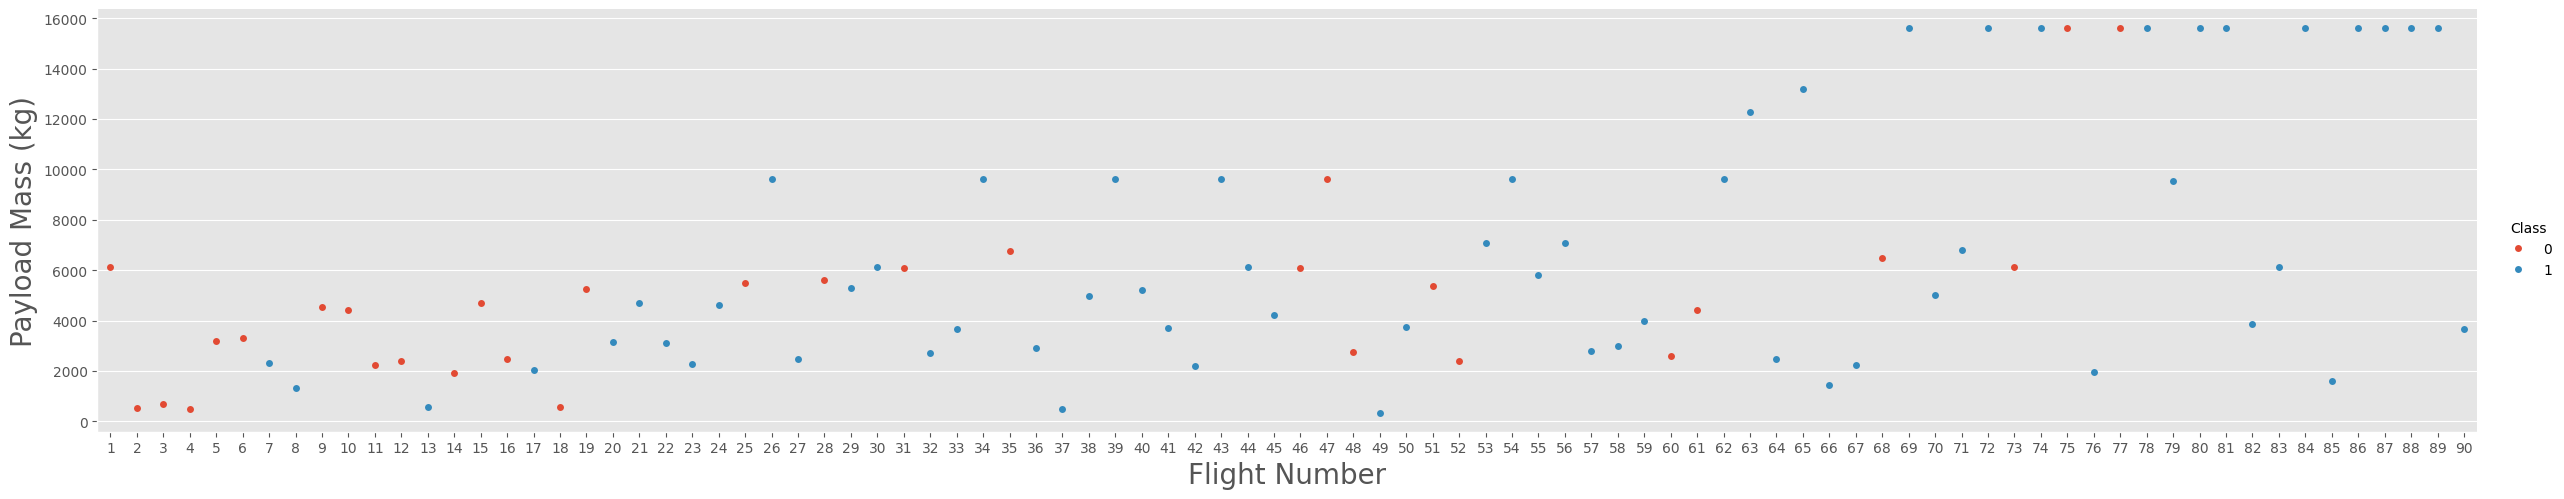

In [59]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
#sns.scatterplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Payload Mass (kg)",fontsize=20)
plt.show()

#### Visualizing the relationship between Flight Number and Launch Site

Using the function <code>catplot</code> we plot <code>FlightNumber</code> vs <code>LaunchSite</code>, we set the parameter <code>hue</code> to <code>'class'</code>


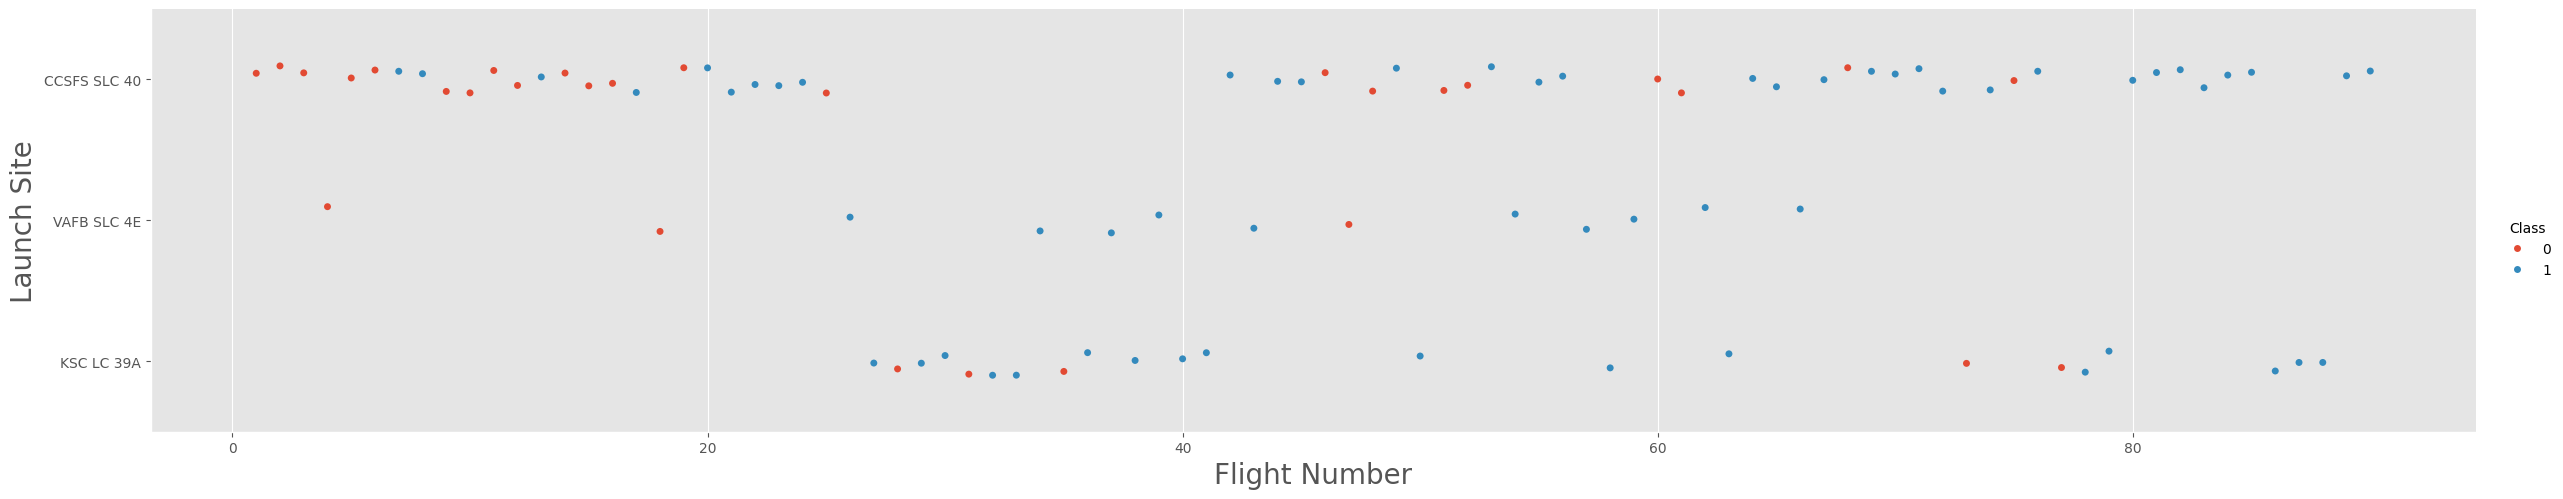

In [60]:
# Plotting a scatter plot with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(y='LaunchSite', x ='FlightNumber', hue = 'Class', data =df, aspect =5)
plt.xlabel('Flight Number', fontsize = 20)
plt.ylabel('Launch Site', fontsize =20)
plt.show()

#### Visualizing the relationship between Payload and Launch Site

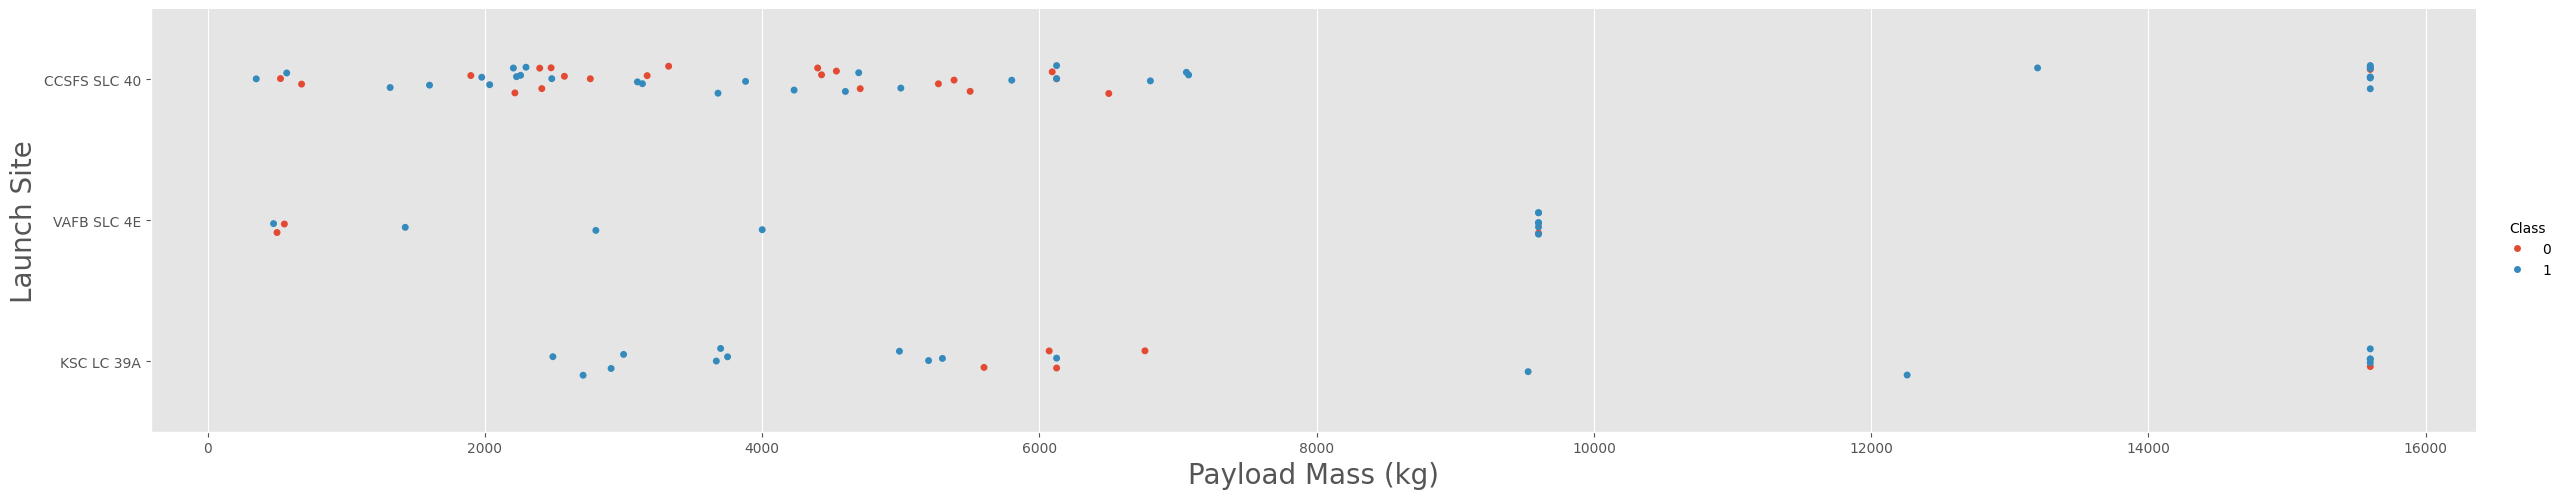

In [61]:
# Plotting a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(y='LaunchSite', x='PayloadMass', hue='Class', data=df, aspect=5)
plt.xlabel('Payload Mass (kg)', fontsize=20)
plt.ylabel('Launch Site', fontsize=20)
plt.show()

Now if you observe Payload Vs. Launch Site scatter point chart you will find for the VAFB-SLC  launchsite there are no  rockets  launched for  heavypayload mass(greater than 10000).


#### Visualizing the relationship between success rate of each orbit type

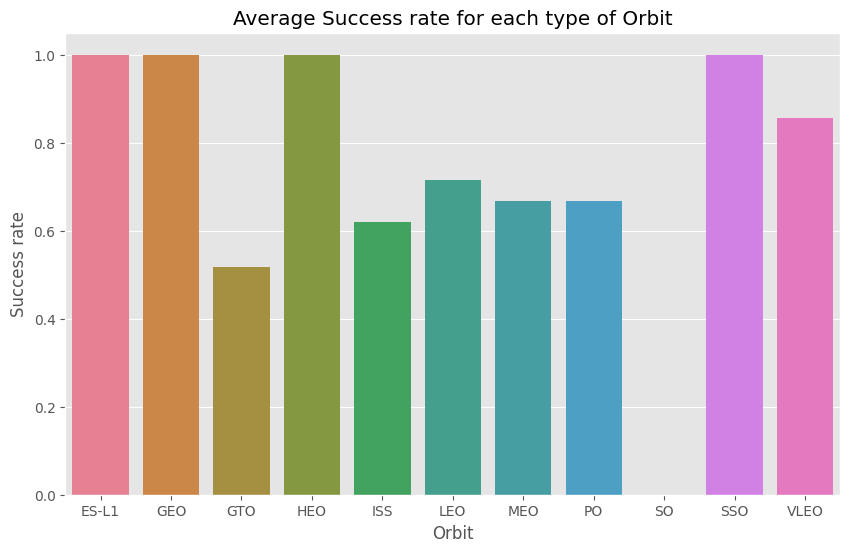

In [62]:
#using groupby method on Orbit column and get the mean of Class column
df_bar = df.groupby('Orbit')['Class'].mean().reset_index()
#df_bar
plt.figure(figsize=(10,6))
sns.barplot(x='Orbit', y='Class', data = df_bar, hue ='Orbit')
plt.xlabel('Orbit')
plt.ylabel('Success rate')
plt.title('Average Success rate for each type of Orbit')
#plt.xticks(labels)
plt.show()

**The orbits ES-L1, GEO, HEO, and SSO have the largest success rate**

#### Visualizing the relationship between FlightNumber and Orbit type

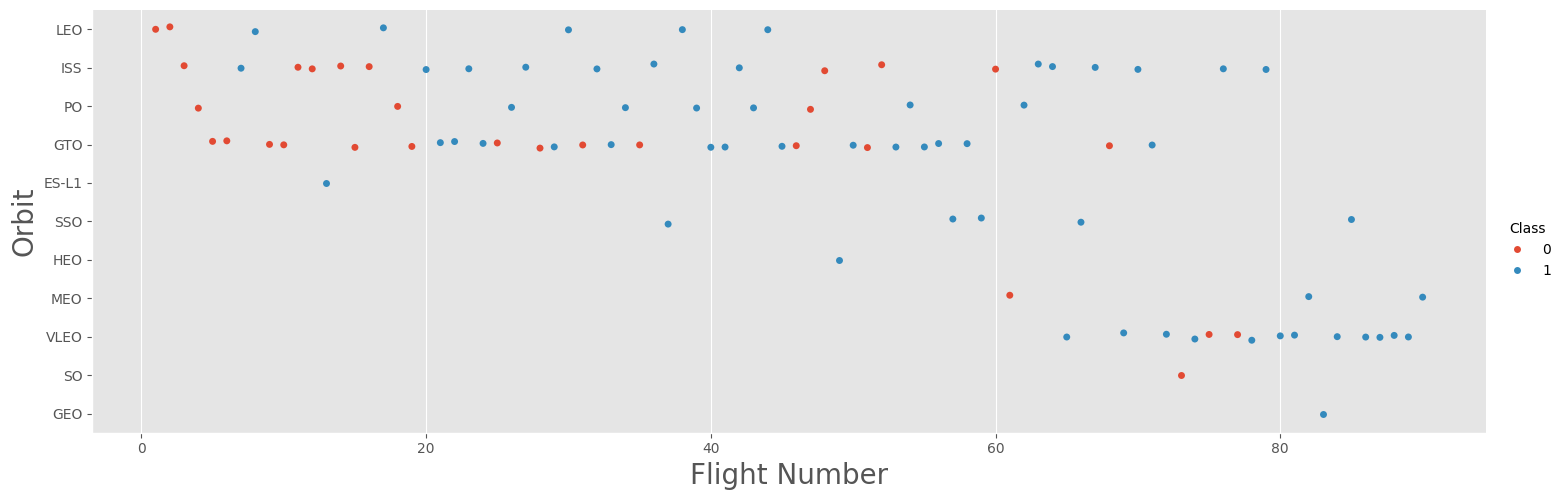

In [63]:
# Plotting a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
#sns.scatterplot(x='FlightNumber', y='Orbit', data=df, hue='Class')
sns.catplot(x='FlightNumber', y='Orbit', data=df, hue='Class', aspect=3)
plt.xlabel('Flight Number', fontsize=20)
plt.ylabel('Orbit', fontsize=20)
plt.show()

We see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit. Also it is clear that the high success rates for the orbits ES-L1, GEO, HEO, and SSO are due to the small number of flights visiting those orbits.

#### Visualizing the relationship between Payload and Orbit type

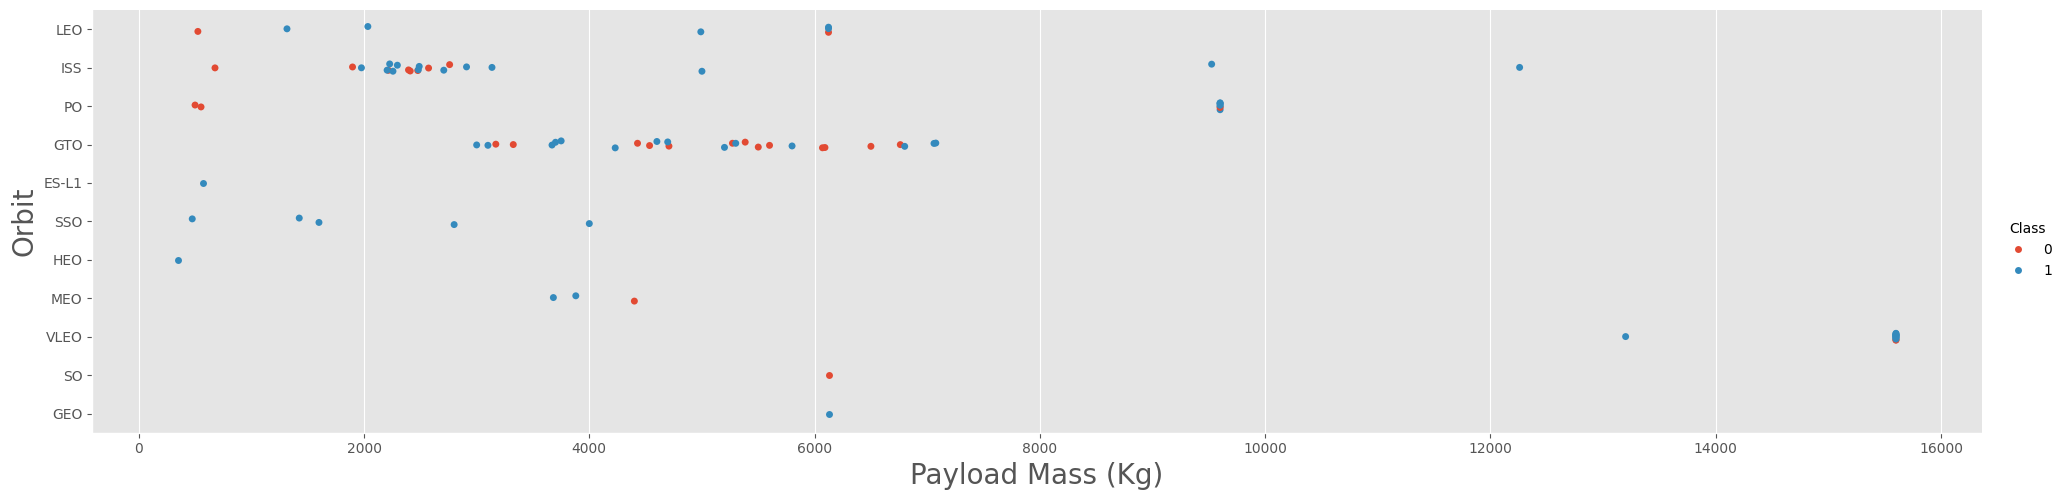

In [64]:
# Plotting a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.catplot(x='PayloadMass', y='Orbit', data =df, hue='Class', aspect = 4)
plt.xlabel('Payload Mass (Kg)', fontsize=20)
plt.ylabel('Orbit', fontsize=20)
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.   

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.




#### Visualizing the launch success yearly trend

Firs we define a function that help to get the year from the date:

In [65]:
# A function to Extract years from the date 
year=[]
def Extract_year(df):
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year

year = Extract_year(df)

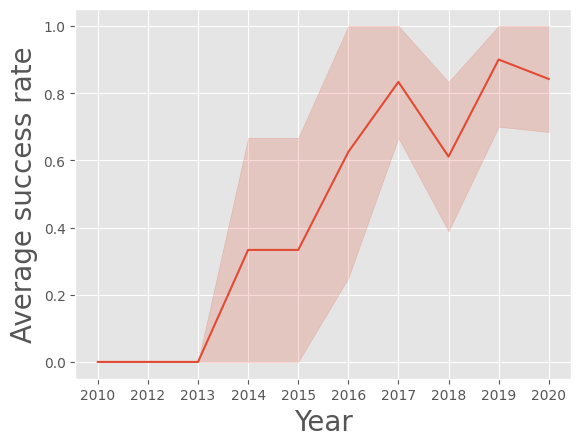

In [66]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
sns.lineplot(x = year, y=list(df['Class'])) 
plt.xlabel('Year', fontsize=20)
plt.ylabel('Average success rate', fontsize=20)
plt.show()
##when the domain has repeated values sns.lineplot takes the average of the images


You can observe that the success rate since 2013 kept increasing till 2017 (stable in 2014) and after 2015 it started increasing.


## Features Engineering 

By now, we have obtain some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction below.

In [67]:
#features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features = df[['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount', 'Orbit', 'LaunchSite', 'LandingPad', 'Serial', 'GridFins', 'Reused', 'Legs']]
features.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit,LaunchSite,LandingPad,Serial,GridFins,Reused,Legs
0,1,6123.547647,1,1.0,0,LEO,CCSFS SLC 40,NaN,B0003,False,False,False
1,2,525.000000,1,1.0,0,LEO,CCSFS SLC 40,NaN,B0005,False,False,False
2,3,677.000000,1,1.0,0,ISS,CCSFS SLC 40,NaN,B0007,False,False,False
3,4,500.000000,1,1.0,0,PO,VAFB SLC 4E,NaN,B1003,False,False,False
4,5,3170.000000,1,1.0,0,GTO,CCSFS SLC 40,NaN,B1004,False,False,False


#### Create dummy variables for categorical columns and casting all numeric columns to float64

In [68]:
##selecting categorical columns
features_cat = features.select_dtypes(include = ['object'])
features_cat.head()

,Orbit,LaunchSite,LandingPad,Serial
0,LEO,CCSFS SLC 40,NaN,B0003
1,LEO,CCSFS SLC 40,NaN,B0005
2,ISS,CCSFS SLC 40,NaN,B0007
3,PO,VAFB SLC 4E,NaN,B1003
4,GTO,CCSFS SLC 40,NaN,B1004


In [69]:
##dealing with missing values
features_cat.isnull().sum()

Orbit          0
LaunchSite     0
LandingPad    26
Serial         0
dtype: int64

In [70]:
##replacing missing values with the most frequent values. This was used because the number of rows with 
#missing values was large. For simplicity I chose to replace with the most frequent values, It might be a better
##idea to develope a model to predict the missing values.
mode_LandingPad = features_cat.LandingPad.mode()
features_cat.loc[:, 'LandingPad'] = features_cat.LandingPad.fillna(mode_LandingPad[0])
print(features_cat.isnull().sum())
features_cat.head()

Orbit         0
LaunchSite    0
LandingPad    0
Serial        0
dtype: int64


,Orbit,LaunchSite,LandingPad,Serial
0,LEO,CCSFS SLC 40,5e9e3032383ecb6bb234e7ca,B0003
1,LEO,CCSFS SLC 40,5e9e3032383ecb6bb234e7ca,B0005
2,ISS,CCSFS SLC 40,5e9e3032383ecb6bb234e7ca,B0007
3,PO,VAFB SLC 4E,5e9e3032383ecb6bb234e7ca,B1003
4,GTO,CCSFS SLC 40,5e9e3032383ecb6bb234e7ca,B1004


In [71]:
##one hot encoder using get_dummies function
features_one_hot = pd.get_dummies(features_cat, dtype = float)
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# data frame with features and the dummy variables
features_plus_one_hot = pd.concat([features, features_one_hot], axis=1)
##removing the  categorical variables
features_plus_one_hot.drop(['Orbit', 'LaunchSite', 'LandingPad', 'Serial'], axis=1, inplace=True)
##casting all columns to float64
features_plus_one_hot = features_plus_one_hot.astype('float64', copy=True, errors = 'raise')
##above, if copy=False does the changes in place, sometimes does not work well though
print(features_plus_one_hot.dtypes)
features_plus_one_hot.head()

FlightNumber    float64
PayloadMass     float64
Flights         float64
Block           float64
ReusedCount     float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object


,FlightNumber,PayloadMass,Flights,Block,ReusedCount,GridFins,Reused,Legs,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can now export it to a <b>CSV</b> to be used later.

In [73]:
features_plus_one_hot.to_csv('dataset_part_3.csv', index=False)

# Launch sites locations analysis with folium

In [24]:
#!pip3 install folium
#!pip3 install wget

In [74]:
#importing the libraries
import folium
import wget
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

**Marking launch sites on a Map**

The following dataset with the name `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site. 


In [75]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)

100% [................................................................................] 7710 / 7710

In [76]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


We first create a map with the Launch locations, then we use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. 

In [77]:
# Initial the map
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
CCAFS_LC_40_coordinate = [28.562302, -80.577356]
CCAFS_SLC_40_coordinate = [28.563197, -80.576820]
KSC_LC_39A_coordinate = [28.573255, -80.646895]
VAFB_SLC_4E_coordinate = [34.632834, -120.610745]

circle_CCAFS_LS_40 = folium.Circle(CCAFS_LC_40_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('CCAFS_LC_40'))
circle_CCAFS_SLC_40 = folium.Circle(CCAFS_SLC_40_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('CCAFS_SLC_40'))
circle_KSC_LC_39A = folium.Circle(KSC_LC_39A_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('KSC_LC_39A'))
circle_VAFB_SLC_4E = folium.Circle(VAFB_SLC_4E_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('VAFB_SLC_4E'))

marker_CCAFS_LC_40 = folium.map.Marker(
    CCAFS_LC_40_coordinate, 
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'CCAFS_LC_40',
        )
    )
marker_CCAFS_SLC_40 = folium.map.Marker(CCAFS_SLC_40_coordinate,
                            icon=DivIcon(icon_size=(20,20),
                                         icon_anchor = (0,0),
                                        html ='<div style = "font-size: 12; color:#d35400;"><b>%s</b></div>' % 'CCAFS_SLC_40',
                                        )
                                       )
marker_KSC_LC_39A = folium.map.Marker(KSC_LC_39A_coordinate,
                            icon=DivIcon(icon_size = (20,20),
                                         icon_anchor = (0,0),
                                        html='<div style = "font-size: 12; color:#d35400;"><b>%s</b></div>' % 'KSC_LC_39A',
                                        )
                                     )
marker_VAFB_SLC_4E = folium.map.Marker(VAFB_SLC_4E_coordinate,
                            icon=DivIcon(icon_size =(20,20),
                                         icon_anchor = (0,0),
                                        html='<div style = "font-size: 12; color:#d35400;"><b>%s</b></div>' % 'VAFB_SLC_4E',
                                        )
                                      )

site_map.add_child(circle_CCAFS_LS_40)
site_map.add_child(circle_CCAFS_SLC_40)
site_map.add_child(circle_KSC_LC_39A)
site_map.add_child(circle_VAFB_SLC_4E)

site_map.add_child(marker_CCAFS_LC_40)
site_map.add_child(marker_CCAFS_SLC_40)
site_map.add_child(marker_KSC_LC_39A)
site_map.add_child(marker_VAFB_SLC_4E)


**Marking the success/failed launches for each site on the map**

Let's first create a `MarkerCluster` object


In [78]:
marker_cluster = MarkerCluster()

In [79]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


For each launch result in `spacex_df` data frame, we add a `folium.marker` to `marker_cluster`

In [80]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame wecreate a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    marker = folium.Marker([record['Lat'], record['Long']],
                          icon = folium.Icon(color='white', icon_color=record['marker_color']))
    marker_cluster.add_child(marker)
site_map

**Calculating distance between launch sites**

Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [81]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)

We can calculate the distance between two points on the map based on their `Lat` and `Long` values using the following method:

In [82]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

#this uses  haversine formula, distance given in km

In [83]:
#distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_1 = calculate_distance(CCAFS_LC_40_coordinate[0], CCAFS_LC_40_coordinate[1], CCAFS_SLC_40_coordinate[0], CCAFS_SLC_40_coordinate[1])
distance_2 = calculate_distance(CCAFS_LC_40_coordinate[0], CCAFS_LC_40_coordinate[1], KSC_LC_39A_coordinate[0], KSC_LC_39A_coordinate[1])
distance_3 = calculate_distance(CCAFS_LC_40_coordinate[0], CCAFS_LC_40_coordinate[1], VAFB_SLC_4E_coordinate[0], VAFB_SLC_4E_coordinate[1])

marker_1 = folium.Marker(
    [CCAFS_LC_40_coordinate[0] + 0.001, CCAFS_LC_40_coordinate[1]],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_1),
    )
)
marker_2 = folium.Marker(
    [KSC_LC_39A_coordinate[0] + 0.001, CCAFS_SLC_40_coordinate[1]],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_2),
    )
)
marker_3 = folium.Marker(
    [VAFB_SLC_4E_coordinate[0] + 0.001, VAFB_SLC_4E_coordinate[1]],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_3),
    )
)
site_map.add_child(marker_1)
site_map.add_child(marker_2)
site_map.add_child(marker_3)

In [84]:
##adding lines between launch sites
line_1 = folium.PolyLine(locations= [CCAFS_LC_40_coordinate, CCAFS_SLC_40_coordinate], weight=1)
line_2 = folium.PolyLine(locations = [CCAFS_LC_40_coordinate, KSC_LC_39A_coordinate], weight=1)
line_3 = folium.PolyLine(locations = [CCAFS_LC_40_coordinate, VAFB_SLC_4E_coordinate], weight=1)
site_map.add_child(line_1)
site_map.add_child(line_2)
site_map.add_child(line_3)

# Applying some Machine Learning models to make predictions

In [85]:
##some libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

Function to plot the confusion matrix

In [86]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

##### Loading the dataframes

In [87]:
data = pd.read_csv('dataset_part_2.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [88]:
X = pd.read_csv('dataset_part_3.csv')
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,GridFins,Reused,Legs,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Standarizing the data

In [89]:
## First we create a numpy array for the column class in data
Y = data.Class.to_numpy()

In [90]:
## We standarize the data in X
scaler = preprocessing.StandardScaler()

print(scaler.fit(X))
#print(scaler.mean_)
#print(scaler.var_)
X_scaled = scaler.transform(X, copy=True)
#print(X.head())
print(X.shape, X_scaled.shape)

StandardScaler()
(90, 80) (90, 80)


Splitting the data into training and testing sets:

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state=2)
Y_test.shape, X_test.shape, Y_train.shape, X_train.shape

((18,), (18, 80), (72,), (72, 80))

### Logistic regression with Cross Validation

In [92]:
##parameters for GridSearch 
parameters_lr ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge

lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters_lr, cv=10, n_jobs=-1, verbose=2)
#n_jobs =-1 uses all available processors
#verbose =2, show detailed output during search
logreg_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             verbose=2)

Best estimator for the parameters chosen:

In [93]:
print("tuned hpyerparameters (best parameters): ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print('best estimator: ', logreg_cv.best_estimator_)

tuned hpyerparameters (best parameters):  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8053571428571429
best estimator:  LogisticRegression(C=0.1)


In [94]:
##accuracy of the test and train data
print('accuracy_test_data: ', logreg_cv.score(X_test, Y_test))
print('accuracy_train_data:', logreg_cv.score(X_train, Y_train))

accuracy_test_data:  0.8333333333333334
accuracy_train_data: 0.9722222222222222


Let's look at the confusion matrix:

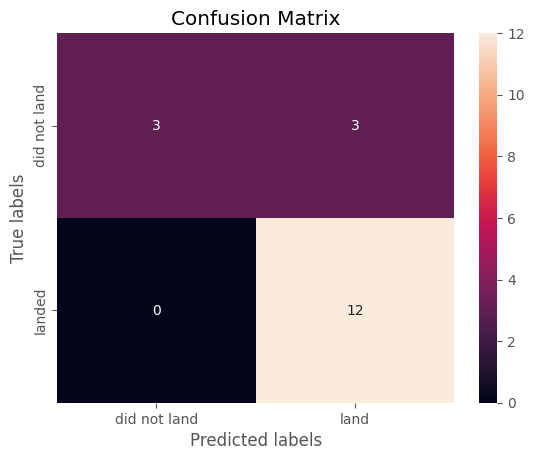

In [95]:
yhat_lr=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_lr)

Overview: \
True positives = 12 (true label landed, predicted label also landed) \
False positives = 3 (true label did not land, predicted label landed) 

### Support Vector Machine with Cross Validation

In [96]:
## parameters for GridSearch

parameters_svm = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(-3,3,5), 
                  'gamma': np.logspace(-3,4,5)}
svm = SVC()
svm_cv = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=10, n_jobs=-1) #, verbose=2)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 5.62341325e-02, 3.16227766e+00, 1.77827941e+02,
       1.00000000e+04]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

Best estimator for the parameters chosen:

In [97]:
print("tuned hpyerparameters (best parameters): ", svm_cv.best_params_)
print("accuracy :", svm_cv.best_score_)
print('best estimator: ', svm_cv.best_estimator_)

tuned hpyerparameters (best parameters):  {'C': 1.0, 'gamma': 0.056234132519034905, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856
best estimator:  SVC(gamma=0.056234132519034905, kernel='sigmoid')


In [98]:
##accuracy of the test and train data

print('accuracy_test_data: ', svm_cv.score(X_test, Y_test))
print('accuracy_train_data:', svm_cv.score(X_train, Y_train))

accuracy_test_data:  0.8333333333333334
accuracy_train_data: 0.8333333333333334


Let's look at the confusion matrix:

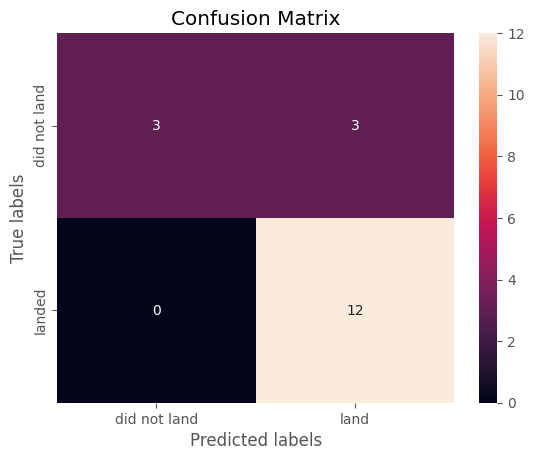

In [99]:
yhat_svm = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat_svm)

Overview: \
True positives = 12 (true label landed, predicted label also landed) \
False positives = 3 (true label did not land, predicted label landed) 

### Decision Tree with Cross Validation

In [108]:
##parameters for GridSearch
parameters_dt  = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': [ 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters_dt, cv=10, n_jobs=-1) #, verbose=2)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

Best estimator for the parameters chosen:

In [109]:
print("tuned hpyerparameters (best parameters): ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)
print("best estimator: ", tree_cv.best_estimator_)

tuned hpyerparameters (best parameters):  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8625
best estimator:  DecisionTreeClassifier(max_depth=14, max_features='sqrt')


In [110]:
## accuracy for the test and train data
print('accuracy_test_data: ', tree_cv.score(X_test, Y_test))
print('accuracy_train_data:', tree_cv.score(X_train, Y_train))

accuracy_test_data:  0.9444444444444444
accuracy_train_data: 1.0


Let's look at the confusion matrix:

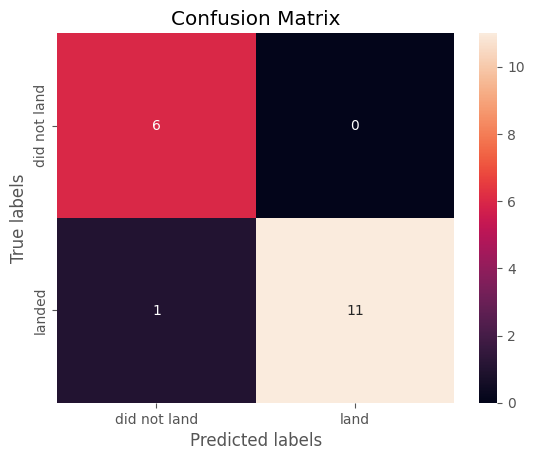

In [111]:
yhat_dt = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_dt)

Overview: \
True positives = 12 (true label landed, predicted label also landed) \
False positives = 1 (true label did not land, predicted label landed) 

### K nearest neighbors with Cross Validation

In [112]:
## parameters for GridSearch
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters_knn, cv=10, n_jobs=-1) #, verbose=2)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

Best estimator for the parameters chosen:

In [113]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)
print('best estimator: ', knn_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
accuracy : 0.8339285714285714
best estimator:  KNeighborsClassifier(n_neighbors=8, p=1)


In [114]:
## accuracy for the test and train data
print('accuracy_test_data: ', knn_cv.score(X_test, Y_test))
print('accuracy_train_data:', knn_cv.score(X_train, Y_train))

accuracy_test_data:  0.8333333333333334
accuracy_train_data: 0.8333333333333334


Let's look at the confusion matrix:

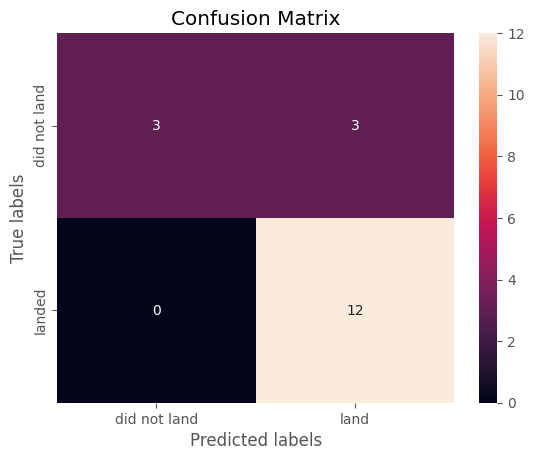

In [115]:
yhat_knn = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_knn)

Overview: \
True positives = 12 (true label landed, predicted label also landed) \
False positives = 3 (true label did not land, predicted label landed) 

## Conclusion

With the parameters chosen, it seems tha the tree performs better